In [ ]:
%pwd

'/content'

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
file = "drive/MyDrive/energy_data/COMED_hourly.csv"

In [ ]:
df = pd.read_csv(file)

In [ ]:
df.head()

,Datetime,COMED_MW
0,2011-12-31 01:00:00,9970.0
1,2011-12-31 02:00:00,9428.0
2,2011-12-31 03:00:00,9059.0
3,2011-12-31 04:00:00,8817.0
4,2011-12-31 05:00:00,8743.0


In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [ ]:
df.head()

,Datetime,COMED_MW
0,2011-12-31 01:00:00,9970.0
1,2011-12-31 02:00:00,9428.0
2,2011-12-31 03:00:00,9059.0
3,2011-12-31 04:00:00,8817.0
4,2011-12-31 05:00:00,8743.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66497 entries, 0 to 66496
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  66497 non-null  datetime64[ns]
 1   COMED_MW  66497 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB


In [ ]:
df.set_index("Datetime", inplace=True)

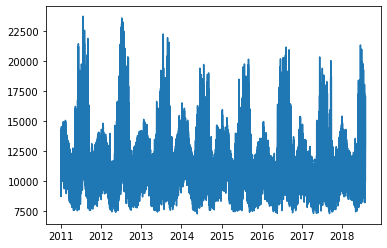

In [ ]:
plt.plot(df)

In [ ]:
df.shape

(66497, 1)

In [ ]:
df_test = df.sort_values(by='Datetime',ascending=True)

In [ ]:
df.head(3)

,COMED_MW
Datetime,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0


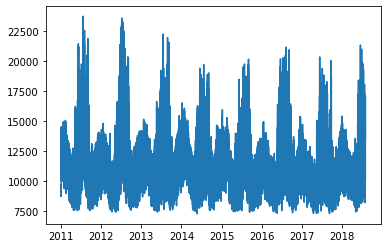

In [ ]:
plt.plot(df_test)
plt.show()

In [ ]:
daily_cases = df.copy()

In [ ]:
training_set = df_test.copy()

In [ ]:
daily_cases.shape

(66497, 1)

In [ ]:
def sliding_windows(data, seq_length):
  x = []
  y = []

  for i in range(len(data)-seq_length-1):
    _x = data[i:(i+seq_length)]
    _y = data[i+seq_length]
    x.append(_x)
    y.append(_y)

  return np.array(x), np.array(y)

In [ ]:
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 12
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y)*0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
class LSTM(nn.Module):

  def __init__(self, num_classes, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()

    self.num_classes = num_classes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_size=input_size, 
                        hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    
    self.fc = nn.Linear(hidden_size, num_classes)
  
  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

    ula, (h_out, _) = self.lstm(x, (h_0, c_0))

    h_out = h_out.view(-1, self.hidden_size)

    out = self.fc(h_out)

    return out


In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  outputs = lstm(trainX)
  optimizer.zero_grad()

  loss = criterion(outputs, trainY)

  loss.backward()

  optimizer.step()
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


Epoch: 0, loss: 0.16143
Epoch: 100, loss: 0.00625
Epoch: 200, loss: 0.00209
Epoch: 300, loss: 0.00109
Epoch: 400, loss: 0.00068
Epoch: 500, loss: 0.00047
Epoch: 600, loss: 0.00036
Epoch: 700, loss: 0.00030
Epoch: 800, loss: 0.00027
Epoch: 900, loss: 0.00025
Epoch: 1000, loss: 0.00023
Epoch: 1100, loss: 0.00022
Epoch: 1200, loss: 0.00022
Epoch: 1300, loss: 0.00021
Epoch: 1400, loss: 0.00021
Epoch: 1500, loss: 0.00021
Epoch: 1600, loss: 0.00021
Epoch: 1700, loss: 0.00020
Epoch: 1800, loss: 0.00020
Epoch: 1900, loss: 0.00020


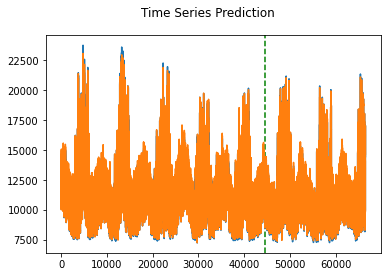

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='g', linestyle='--')


#plt.figure(figsize=(15,8))

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time Series Prediction')
plt.show()
